# Exploratory data analysis  
## Dataset: English Wikipedia clickstream for December 2018

In [1]:
import re

import requests

# import html parsers before BeautifulSoup
import lxml

from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import networkx as nx

from timeit import default_timer as timer

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import powerlaw

In [2]:
# Customize matplotlib default settings
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
# set up Pandas options
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 3)
pd.options.display.float_format = '{:.2f}'.format

#### Read in the data

In [4]:
# Read the cleaned up EN clickstream tsv file into pandas
filepath = "../data/clickstream-enwiki-2018-12_clean.tsv"
df = pd.read_csv(filepath, sep='\t', names=['prev', 'curr', 'type', 'n'])

In [5]:
# Replace the false missing value NaNs with string "NaN"s
df['prev'] = df['prev'].fillna('NaN')
df['curr'] = df['curr'].fillna('NaN')

In [6]:
df.head()

,prev,curr,type,n
0,other-empty,2019_Horizon_League_Baseball_Tournament,external,16
1,other-search,ForeverAtLast,external,40
2,other-empty,ForeverAtLast,external,85
3,First_Families_of_Pakistan,Jehangir_Wadia,link,19
4,"The_Lawrence_School,_Sanawar",Jehangir_Wadia,link,36


In [7]:
df.describe(include='all')

,prev,curr,type,n
count,29847736,29847736,29847736,29847736.00
unique,1714260,5183771,3,nan
top,other-empty,Hyphen-minus,link,nan
freq,5093433,127578,17851574,nan
mean,NaN,NaN,NaN,230.46
std,NaN,NaN,NaN,90303.30
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,15.00
50%,NaN,NaN,NaN,28.00
75%,NaN,NaN,NaN,71.00


In [10]:
df.sort_values("n", ascending=False, inplace=True)

In [25]:
edge_traffic_frequencies = df.n.value_counts()

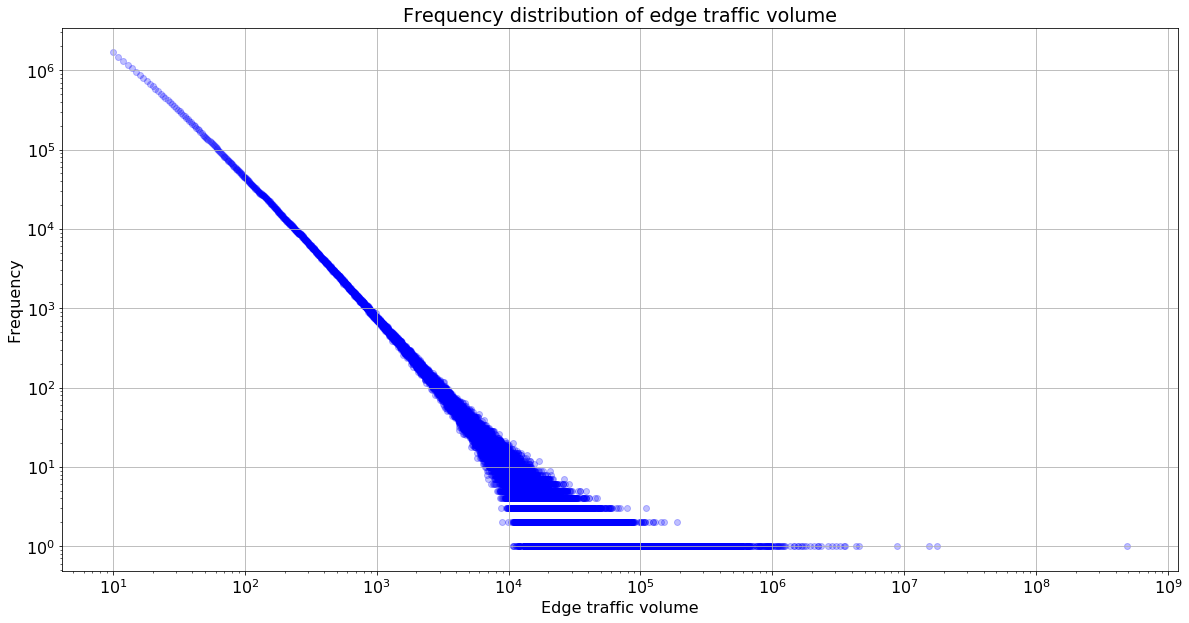

In [48]:
my_alpha = 0.25
plt.scatter(edge_traffic_frequencies.index.values, edge_traffic_frequencies.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of edge traffic volume");

The clickstream dataset is a collection of referer-requested webpage pairs (edges) with aggregated traffic count for the pair within the given month. These edges are of 3 types in the data: **external**, **link** and **other**. The external type means that the referer webpage is some webpage outside of the English Wikipedia.  

The exact **external** referer webpages are not specified in the data, and are instead aggregated into 5 categories (as decribed [here](https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream#Data_Preparation)):  
- **other-external**: External website referers, i.e. the user went from some external website to a Wikipedia article page.  
- **other-search**: External search referers, i.e. the user searched for something on a search engine page and from there went to a Wikipedia article page.
- **other-internal**: Referers from some other Wikimedia project. It could be a different language Wikipedia or some other Wikimedia project that is not a Wikipedia.
- **other-empty**: An empty referer. This can be the result of a browser homepage setting, a security measure, a bot, etc.
- **other-other**: Any other external referer.  

The **link** and **other** reference types are both for edges connecting Wikipedia articles. The **link** type means that the user followed a link from one Wikipedia article to another. And the **other** type means that the user went from one Wikipedia article to another, but there was no link between them. This happens if the user gets to the second article by searching from the first article, or if the referer is spoofed.

Here's the distribution of traffic volume and edge counts across the 3 reference types.

In [11]:
edges_count = df.groupby("type").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = df.groupby("type").n.sum()
traffic_volume.rename("traffic_volume", inplace=True)

summary_by_type = pd.concat([edges_count, traffic_volume], axis=1)
summary_by_type["edges_count_pct"] = summary_by_type["edges_count"] / summary_by_type["edges_count"].sum()
summary_by_type["traffic_volume_pct"] = summary_by_type["traffic_volume"] / summary_by_type["traffic_volume"].sum()

summary_by_type

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
type,,,,
external,10990982,5100299091,0.37,0.74
link,17851574,1718399222,0.60,0.25
other,1005180,60022438,0.03,0.01


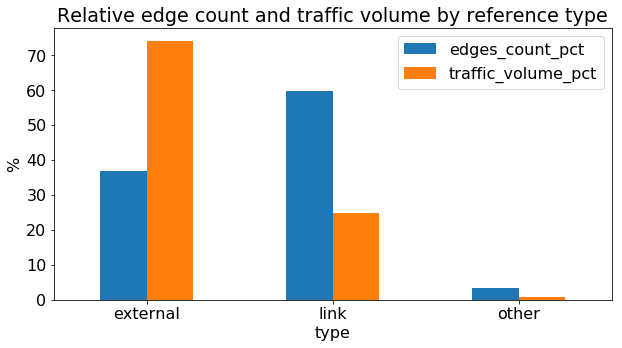

In [12]:
ax = plt.gca()
(summary_by_type[["edges_count_pct", "traffic_volume_pct"]]*100).plot(kind = "bar", ax=ax)
plt.xticks(np.arange(len(summary_by_type.index)), summary_by_type.index, rotation=0)
ax.set_title("Relative edge count and traffic volume by reference type")
ax.set_ylabel("%")

# adjust this fig size
fig = plt.gcf()
fig.set_size_inches(10,5);

In [16]:
external_edges = df[df.type == 'external']
link_edges = df[df.type == 'link']
other_edges = df[df.type == 'other']

In [25]:
external_edges_traffic_frequencies = external_edges.n.value_counts()
link_edges_traffic_frequencies = link_edges.n.value_counts()
other_edges_traffic_frequencies = other_edges.n.value_counts()

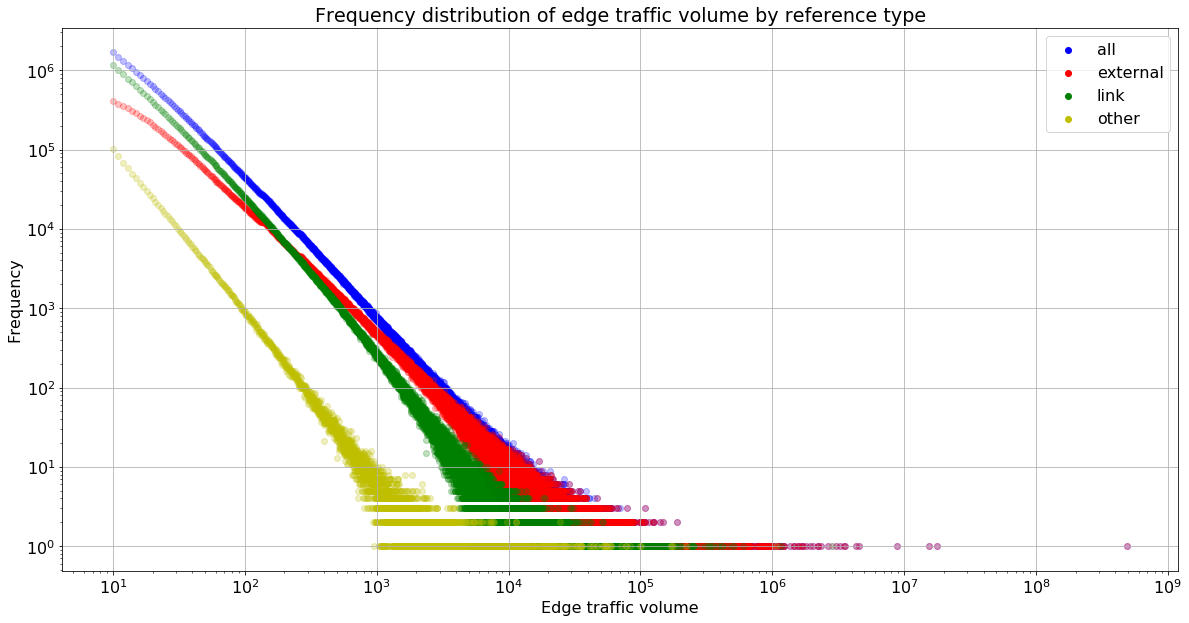

In [77]:
my_alpha = 0.25
plt.scatter(edge_traffic_frequencies.index.values, edge_traffic_frequencies.values, \
            c="b", label="all", alpha=my_alpha)
plt.scatter(external_edges_traffic_frequencies.index.values, external_edges_traffic_frequencies.values, \
            c="r", label="external", alpha=my_alpha)
plt.scatter(link_edges_traffic_frequencies.index.values, link_edges_traffic_frequencies.values, \
            c="g", label="link", alpha=my_alpha)
plt.scatter(other_edges_traffic_frequencies.index.values, other_edges_traffic_frequencies.values, \
            c="y", label="other", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()

# make the legend markers opaque
for lh in plt.gca().legend().legendHandles:
    lh.set_alpha(1)


plt.title("Frequency distribution of edge traffic volume by reference type");

### External reference type

In [17]:
external_edges.describe(include='all')

,prev,curr,type,n
count,10990982,10990982,10990982,10990982.00
unique,5,5163109,1,nan
top,other-empty,Richard_Boone,external,nan
freq,5093433,5,10990982,nan
mean,NaN,NaN,NaN,464.04
std,NaN,NaN,NaN,148805.73
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,18.00
50%,NaN,NaN,NaN,38.00
75%,NaN,NaN,NaN,121.00


In [85]:
external_edges.head(20)

,prev,curr,type,n
7908180,other-empty,Main_Page,external,492341152
772288,other-external,Hyphen-minus,external,17676430
765759,other-empty,Hyphen-minus,external,15498618
7831692,other-internal,Main_Page,external,8826536
21252458,other-search,George_H._W._Bush,external,4576854
3488262,other-empty,XHamster,external,4281194
23951757,other-search,Jason_Momoa,external,3538068
18403529,other-search,2.0_(film),external,3475113
1830737,other-search,Bird_Box_(film),external,3251996
7897786,other-search,Main_Page,external,3020671


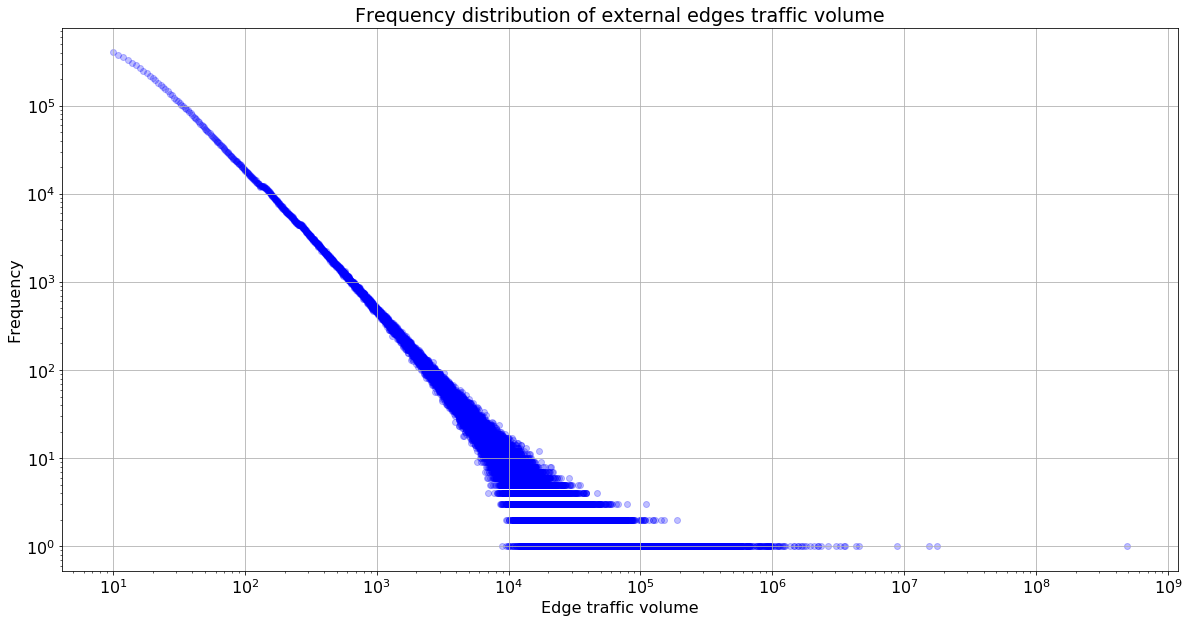

In [55]:
my_alpha = 0.25
plt.scatter(external_edges_traffic_frequencies.index.values, external_edges_traffic_frequencies.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of external edges traffic volume");

In [50]:
edges_count = external_edges.groupby("prev").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = external_edges.groupby("prev").n.sum()
traffic_volume.rename("traffic_volume", inplace=True)

summary_by_type = pd.concat([edges_count, traffic_volume], axis=1)
summary_by_type["edges_count_pct"] = summary_by_type["edges_count"] / summary_by_type["edges_count"].sum()
summary_by_type["traffic_volume_pct"] = summary_by_type["traffic_volume"] / summary_by_type["traffic_volume"].sum()

summary_by_type

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
prev,,,,
other-empty,5093433,1779965188,0.46,0.35
other-external,787311,116732857,0.07,0.02
other-internal,1348892,132349844,0.12,0.03
other-other,374921,36972380,0.03,0.01
other-search,3386425,3034278822,0.31,0.59


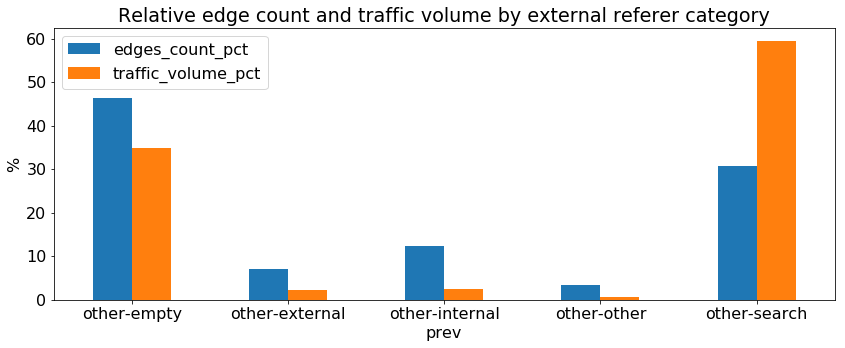

In [54]:
ax = plt.gca()
(summary_by_type[["edges_count_pct", "traffic_volume_pct"]]*100).plot(kind = "bar", ax=ax)
plt.xticks(np.arange(len(summary_by_type.index)), summary_by_type.index, rotation=0)
ax.set_title("Relative edge count and traffic volume by external referer category")
ax.set_ylabel("%")

# adjust this fig size
fig = plt.gcf()
fig.set_size_inches(14,5);

In [57]:
external_websites_edges = external_edges[external_edges.prev == 'other-external']
external_search_edges = external_edges[external_edges.prev == 'other-search']
other_wikimedia_edges = external_edges[external_edges.prev == 'other-internal']
empty_referer_edges = external_edges[external_edges.prev == 'other-empty']
external_other_edges = external_edges[external_edges.prev == 'other-other']

In [67]:
external_websites_edges.name = "external_websites"
external_search_edges.name = "external_search"
other_wikimedia_edges.name = "other_wikimedia"
empty_referer_edges.name = "empty_referer"
external_other_edges.name = "external_other"

In [68]:
external_edges_freq_dict = {}
external_edges_list = \
    [external_websites_edges, external_search_edges, other_wikimedia_edges, empty_referer_edges, external_other_edges]
for e in external_edges_list:
    external_edges_freq_dict[e.name] = e.n.value_counts()

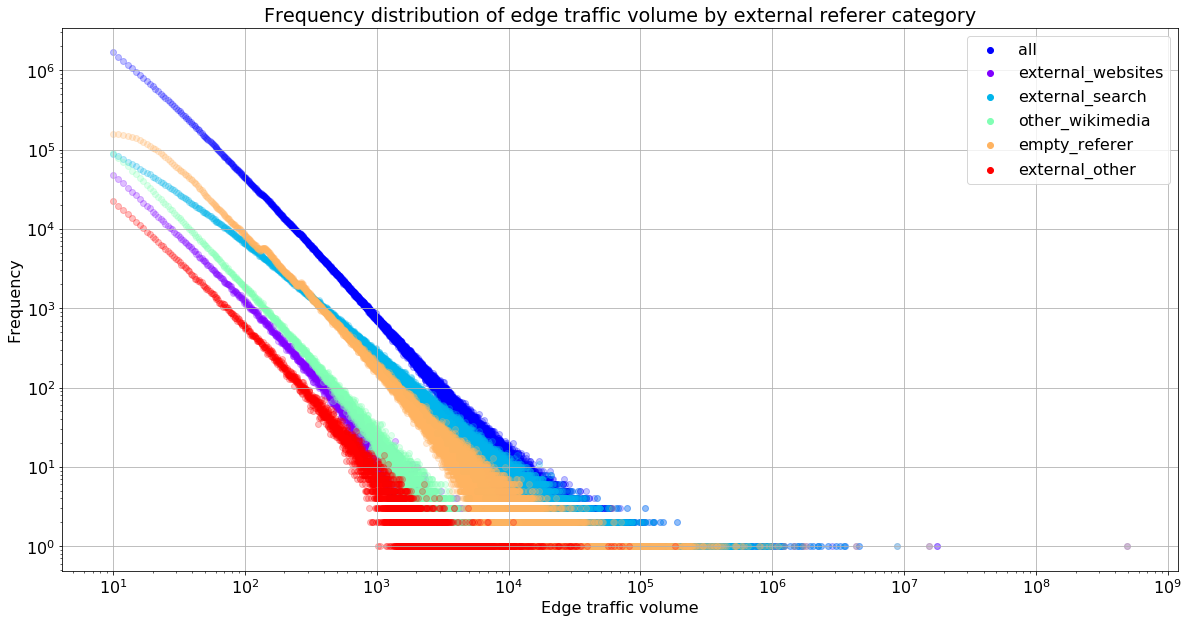

In [76]:
my_alpha = 0.25
colors = matplotlib.cm.rainbow(np.linspace(0, 1, 5))
i = 0
plt.scatter(edge_traffic_frequencies.index.values, edge_traffic_frequencies.values, \
            c="b", label="all", alpha=my_alpha)
for key in external_edges_freq_dict:
    plt.scatter(external_edges_freq_dict[key].index.values, external_edges_freq_dict[key].values, \
            c=[colors[i]], label=key, alpha=my_alpha)
    i+=1
    
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()

# make the legend markers opaque
for lh in plt.gca().legend().legendHandles:
    lh.set_alpha(1)

plt.title("Frequency distribution of edge traffic volume by external referer category");

In [82]:
from IPython.display import display

In [84]:
for e in external_edges_list:
    print("External referer category:", e.name)
    print("Descriptive stats")
    display(e.describe(include='all'))
    print("Top 20 observations")
    display(e.head(20))
    print("=====================")

External referer category: external_websites
Descriptive stats


,prev,curr,type,n
count,787311,787311,787311,787311.00
unique,1,787311,1,nan
top,other-external,Soul_II_Soul,external,nan
freq,787311,1,787311,nan
mean,NaN,NaN,NaN,148.27
std,NaN,NaN,NaN,19997.55
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,15.00
50%,NaN,NaN,NaN,27.00
75%,NaN,NaN,NaN,66.00


Top 20 observations


,prev,curr,type,n
772288,other-external,Hyphen-minus,external,17676430
7911237,other-external,Main_Page,external,677294
17715549,other-external,HTTP_404,external,636210
7013418,other-external,Toilet-related_injuries_and_deaths,external,499771
9345692,other-external,Kotii_Reddy,external,365723
4678252,other-external,Vilnius,external,239233
13233515,other-external,OpenText,external,209113
2365108,other-external,Singapore,external,209027
21826646,other-external,China,external,169522
5577541,other-external,2015_Tianjin_explosions,external,168136


External referer category: external_search
Descriptive stats


,prev,curr,type,n
count,3386425,3386425,3386425,3386425.00
unique,1,3386425,1,nan
top,other-search,Forbes_Bank,external,nan
freq,3386425,1,3386425,nan
mean,NaN,NaN,NaN,896.01
std,NaN,NaN,NaN,9169.17
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,24.00
50%,NaN,NaN,NaN,67.00
75%,NaN,NaN,NaN,269.00


Top 20 observations


,prev,curr,type,n
21252458,other-search,George_H._W._Bush,external,4576854
23951757,other-search,Jason_Momoa,external,3538068
18403529,other-search,2.0_(film),external,3475113
1830737,other-search,Bird_Box_(film),external,3251996
7897786,other-search,Main_Page,external,3020671
5686277,other-search,Aquaman_(film),external,2634665
25647123,other-search,Bird_Box,external,2328884
4776244,other-search,Priyanka_Chopra,external,2231176
20229173,other-search,List_of_most-disliked_YouTube_videos,external,2226602
20509526,other-search,Freddie_Mercury,external,2050628


External referer category: other_wikimedia
Descriptive stats


,prev,curr,type,n
count,1348892,1348892,1348892,1348892.00
unique,1,1348892,1,nan
top,other-internal,Mekong_Auto,external,nan
freq,1348892,1,1348892,nan
mean,NaN,NaN,NaN,98.12
std,NaN,NaN,NaN,7675.69
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,14.00
50%,NaN,NaN,NaN,24.00
75%,NaN,NaN,NaN,57.00


Top 20 observations


,prev,curr,type,n
7831692,other-internal,Main_Page,external,8826536
718456,other-internal,Hyphen-minus,external,1102895
24135220,other-internal,NetScout_Systems,external,164599
5685679,other-internal,Aquaman_(film),external,131946
1830779,other-internal,Bird_Box_(film),external,127234
21252211,other-internal,George_H._W._Bush,external,109536
11460836,other-internal,Alfred_Werner_Maurer,external,99521
2804399,other-internal,Saleem_Dabbour,external,95989
1395045,other-internal,Lists_of_deaths_by_year,external,90288
26953883,other-internal,Spider-Man:_Into_the_Spider-Verse,external,89905


External referer category: empty_referer
Descriptive stats


,prev,curr,type,n
count,5093433,5093433,5093433,5093433.00
unique,1,5093433,1,nan
top,other-empty,Forbes_Bank,external,nan
freq,5093433,1,5093433,nan
mean,NaN,NaN,NaN,349.46
std,NaN,NaN,NaN,218285.52
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,18.00
50%,NaN,NaN,NaN,35.00
75%,NaN,NaN,NaN,100.00


Top 20 observations


,prev,curr,type,n
7908180,other-empty,Main_Page,external,492341152
765759,other-empty,Hyphen-minus,external,15498618
3488262,other-empty,XHamster,external,4281194
17100674,other-empty,Darth_Vader,external,1801074
9889788,other-empty,Segersjön,external,1724261
1395258,other-empty,Lists_of_deaths_by_year,external,1457060
20816436,other-empty,Exo_(band),external,1223507
11283146,other-empty,2018_FIFA_World_Cup,external,1077101
23951884,other-empty,Jason_Momoa,external,990366
6365678,other-empty,Null,external,944711


External referer category: external_other
Descriptive stats


,prev,curr,type,n
count,374921,374921,374921,374921.00
unique,1,374921,1,nan
top,other-other,Soul_II_Soul,external,nan
freq,374921,1,374921,nan
mean,NaN,NaN,NaN,98.61
std,NaN,NaN,NaN,582.40
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,15.00
50%,NaN,NaN,NaN,27.00
75%,NaN,NaN,NaN,66.00


Top 20 observations


,prev,curr,type,n
18403629,other-other,2.0_(film),external,182358
7864821,other-other,Main_Page,external,81647
62341,other-other,Zero_(2018_film),external,72911
800518,other-other,K.G.F:_Chapter_1,external,68387
11367499,other-other,List_of_highest-grossing_Indian_films,external,63234
1519345,other-other,Sexy_Movie,external,59806
26295856,other-other,XXXX,external,57086
27074482,other-other,List_of_Bollywood_films_of_2018,external,39626
4767645,other-other,Blue_Film_Woman,external,35363
4776132,other-other,Priyanka_Chopra,external,34612


### Link reference type

In [18]:
link_edges.describe(include='all')

,prev,curr,type,n
count,17851574,17851574,17851574,17851574.00
unique,1703705,2598302,1,nan
top,New_York_City,United_States,link,nan
freq,2224,6368,17851574,nan
mean,NaN,NaN,NaN,96.26
std,NaN,NaN,NaN,870.84
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,14.00
50%,NaN,NaN,NaN,25.00
75%,NaN,NaN,NaN,56.00


In [87]:
link_edges.head(20)

,prev,curr,type,n
9722110,Jason_Momoa,Lisa_Bonet,link,1166522
6473638,Priyanka_Chopra,Nick_Jonas,link,596798
1830750,Bird_Box,Bird_Box_(film),link,508241
4776073,Nick_Jonas,Priyanka_Chopra,link,493898
23721511,George_H._W._Bush,George_W._Bush,link,453809
6531433,George_H._W._Bush,Pauline_Robinson_Bush,link,419132
18515291,George_H._W._Bush,Barbara_Bush,link,412565
21252092,George_W._Bush,George_H._W._Bush,link,393452
10588026,George_H._W._Bush,Dorothy_Bush_Koch,link,377785
365460,Emily_Atack,Kate_Robbins,link,354577


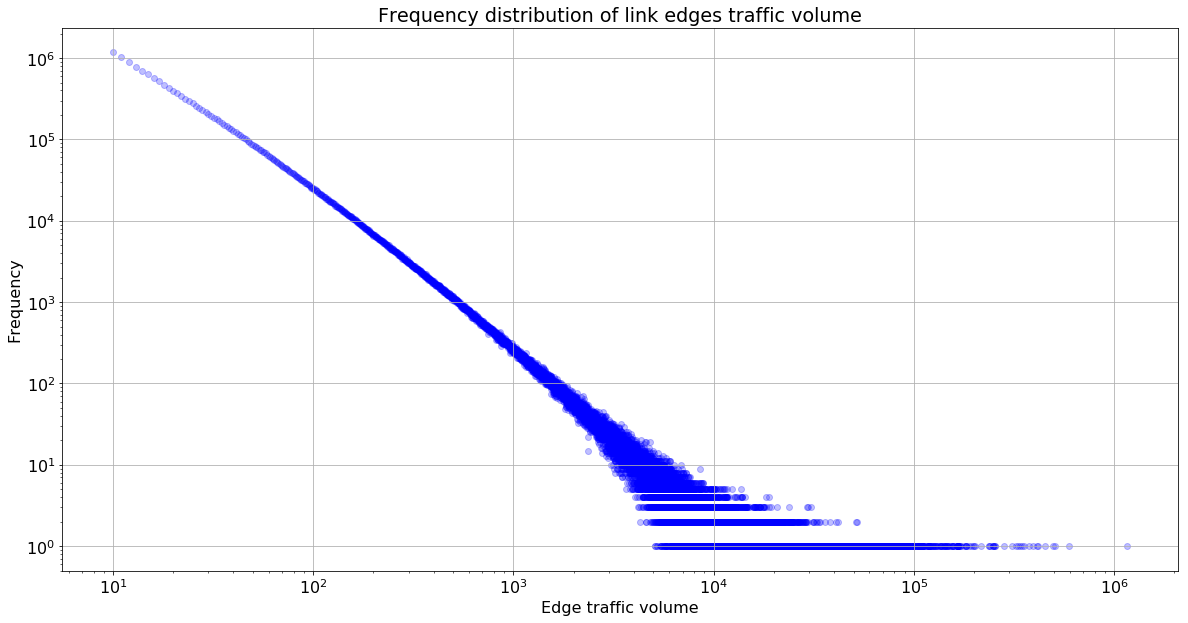

In [86]:
my_alpha = 0.25
plt.scatter(link_edges_traffic_frequencies.index.values, link_edges_traffic_frequencies.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of link edges traffic volume");

#### Top hubs

In [100]:
edges_count = link_edges.groupby("prev").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = link_edges.groupby("prev").n.sum()
traffic_volume.rename("traffic_volume", inplace=True)

start_nodes = pd.concat([edges_count, traffic_volume], axis=1)
start_nodes["edges_count_pct"] = start_nodes["edges_count"] / start_nodes["edges_count"].sum()
start_nodes["traffic_volume_pct"] = start_nodes["traffic_volume"] / start_nodes["traffic_volume"].sum()

In [101]:
start_nodes.sort_values("traffic_volume", ascending=False, inplace=True)

In [107]:
start_nodes.describe()

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
count,1703705.0000,1703705.0000,1703705.0000,1703705.0000
mean,10.4781,1008.6249,0.0000,0.0000
std,25.8979,9291.2455,0.0000,0.0000
min,1.0000,10.0000,0.0000,0.0000
25%,1.0000,26.0000,0.0000,0.0000
50%,3.0000,86.0000,0.0000,0.0000
75%,9.0000,359.0000,0.0000,0.0000
max,2224.0000,4466936.0000,0.0001,0.0026


In [94]:
pd.options.display.float_format = '{:.4f}'.format

In [102]:
start_nodes.head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
prev,,,,
George_H._W._Bush,811,4466936,0.0000,0.0026
Aquaman_(film),250,2391941,0.0000,0.0014
Jason_Momoa,96,2226611,0.0000,0.0013
Bird_Box_(film),67,2042949,0.0000,0.0012
Spider-Man:_Into_the_Spider-Verse,319,1872733,0.0000,0.0011
Exo_(band),129,1639704,0.0000,0.0010
Macaulay_Culkin,164,1441673,0.0000,0.0008
George_W._Bush,562,1343059,0.0000,0.0008
Priyanka_Chopra,423,1245686,0.0000,0.0007


In [108]:
start_nodes_traffic_freq = start_nodes.traffic_volume.value_counts()

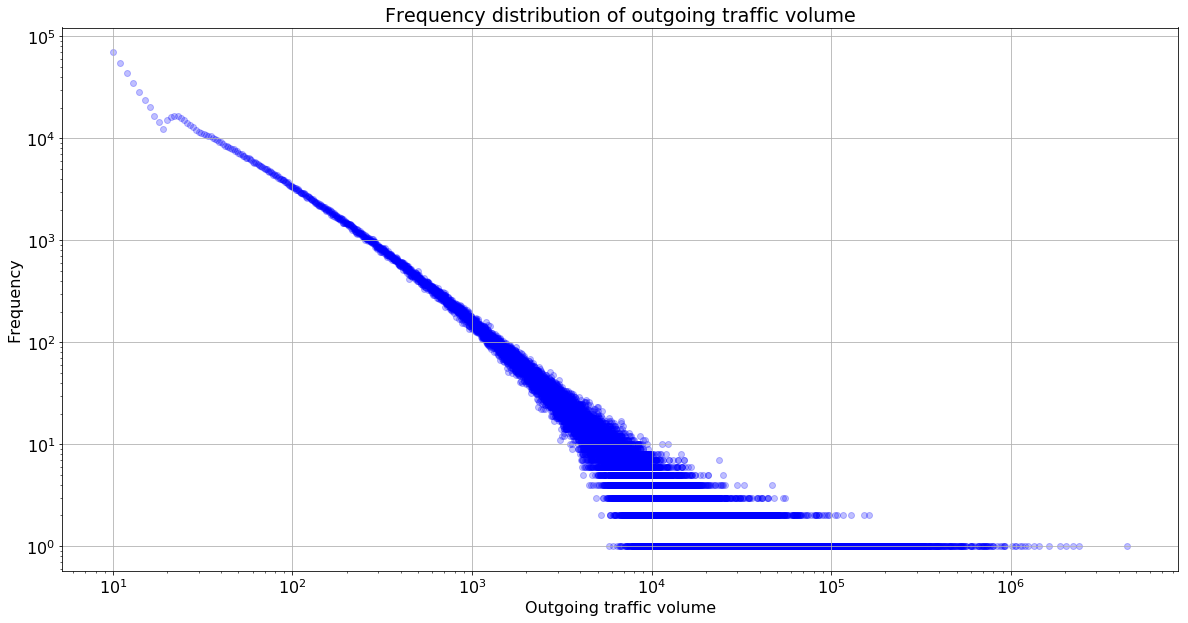

In [121]:
my_alpha = 0.25
plt.scatter(start_nodes_traffic_freq.index.values, start_nodes_traffic_freq.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Outgoing traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of outgoing traffic volume");

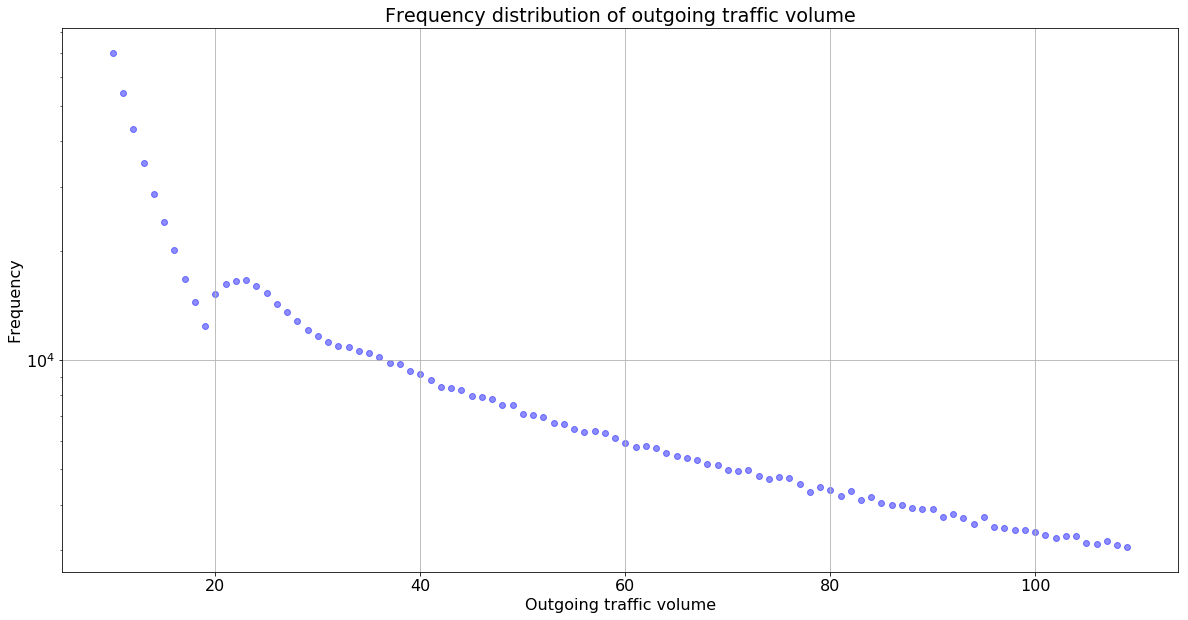

In [154]:
my_alpha = 0.45
plt.scatter(start_nodes_traffic_freq[:100].index.values, start_nodes_traffic_freq[:100].values, \
            c="b", alpha=my_alpha)
#plt.xscale("log")
plt.yscale("log")
plt.xlabel('Outgoing traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of outgoing traffic volume");

In [117]:
start_nodes_traffic_freq.sort_index().head(30)

10    70036
11    54370
12    43368
13    34912
14    28593
15    24009
16    20106
17    16738
18    14452
19    12403
20    15242
21    16179
22    16532
23    16656
24    15954
25    15269
26    14254
27    13566
28    12816
29    12096
30    11607
31    11208
32    10952
33    10892
34    10602
35    10476
36    10161
37     9784
38     9750
39     9301
Name: traffic_volume, dtype: int64

In [139]:
link_edges_100_cutoff = link_edges[link_edges.n >= 100]

In [140]:
edges_count = link_edges_100_cutoff.groupby("prev").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = link_edges_100_cutoff.groupby("prev").n.sum()
traffic_volume.rename("traffic_volume", inplace=True)

start_nodes_c100 = pd.concat([edges_count, traffic_volume], axis=1)
start_nodes_c100["edges_count_pct"] = start_nodes_c100["edges_count"] / start_nodes_c100["edges_count"].sum()
start_nodes_c100["traffic_volume_pct"] = start_nodes_c100["traffic_volume"] / start_nodes_c100["traffic_volume"].sum()

In [141]:
start_nodes_traffic_freq2 = start_nodes_c100.traffic_volume.value_counts()

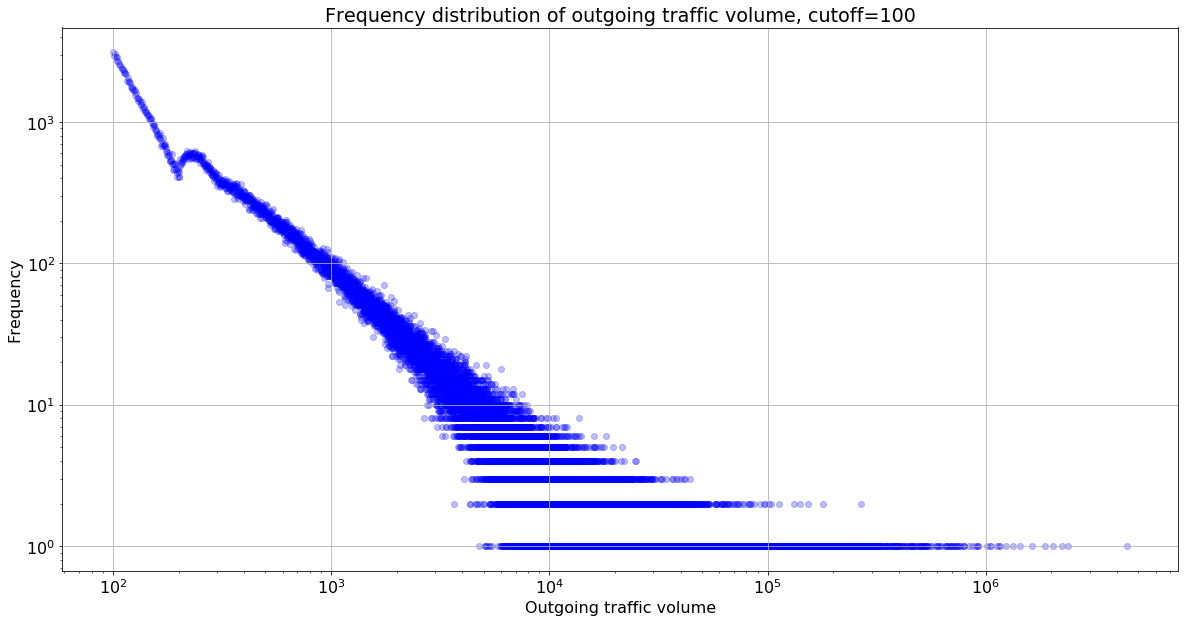

In [145]:
my_alpha = 0.25
plt.scatter(start_nodes_traffic_freq2.index.values, start_nodes_traffic_freq2.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Outgoing traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of outgoing traffic volume, cutoff=100");

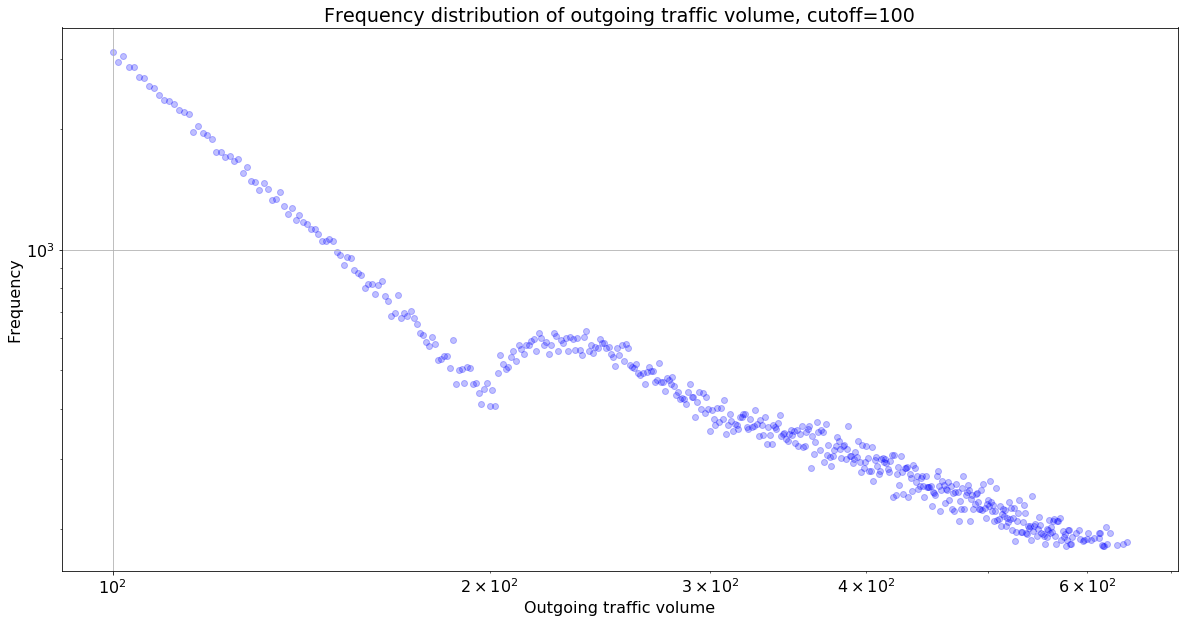

In [147]:
my_alpha = 0.25
plt.scatter(start_nodes_traffic_freq2[:500].index.values, start_nodes_traffic_freq2[:500].values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Outgoing traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of outgoing traffic volume, cutoff=100");

In [148]:
link_edges_500_cutoff = link_edges[link_edges.n >= 500]

In [149]:
edges_count = link_edges_500_cutoff.groupby("prev").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = link_edges_500_cutoff.groupby("prev").n.sum()
traffic_volume.rename("traffic_volume", inplace=True)

start_nodes_c500 = pd.concat([edges_count, traffic_volume], axis=1)
start_nodes_c500["edges_count_pct"] = start_nodes_c500["edges_count"] / start_nodes_c500["edges_count"].sum()
start_nodes_c500["traffic_volume_pct"] = start_nodes_c500["traffic_volume"] / start_nodes_c500["traffic_volume"].sum()

In [150]:
start_nodes_traffic_freq3 = start_nodes_c500.traffic_volume.value_counts()

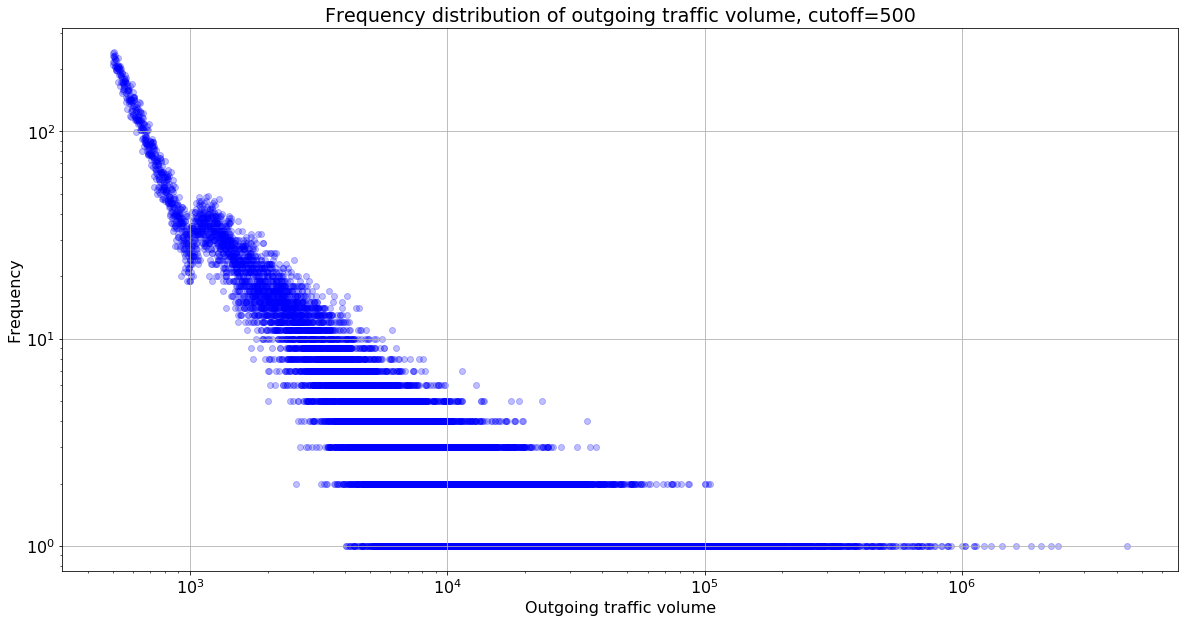

In [151]:
my_alpha = 0.25
plt.scatter(start_nodes_traffic_freq3.index.values, start_nodes_traffic_freq3.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Outgoing traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of outgoing traffic volume, cutoff=500");

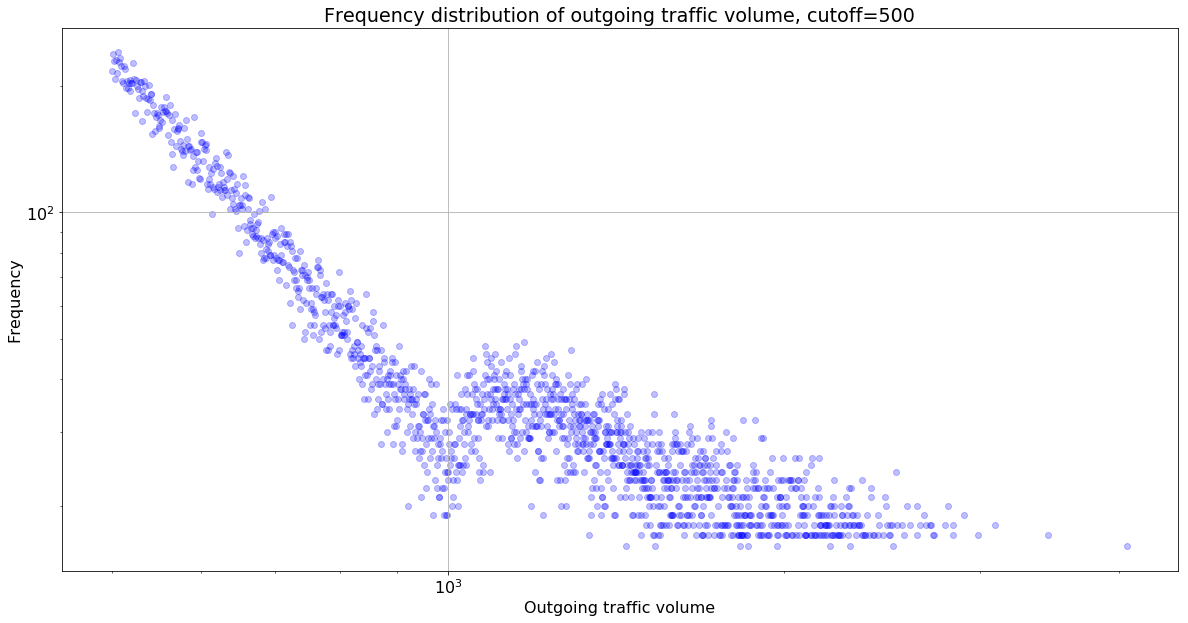

In [153]:
my_alpha = 0.25
plt.scatter(start_nodes_traffic_freq3[:1500].index.values, start_nodes_traffic_freq3[:1500].values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Outgoing traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of outgoing traffic volume, cutoff=500");

In [106]:
start_nodes.sort_values("edges_count", ascending=False).head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
prev,,,,
New_York_City,2224,196519,0.0001,0.0001
London,2061,170028,0.0001,0.0001
William_Shakespeare,2043,231056,0.0001,0.0001
Russia,2039,225218,0.0001,0.0001
California,2039,135372,0.0001,0.0001
France,1874,173974,0.0001,0.0001
United_States,1815,557659,0.0001,0.0003
Paris,1804,106901,0.0001,0.0001
Massachusetts,1753,88968,0.0001,0.0001


In [118]:
start_nodes_edge_counts_freq = start_nodes.edges_count.value_counts()

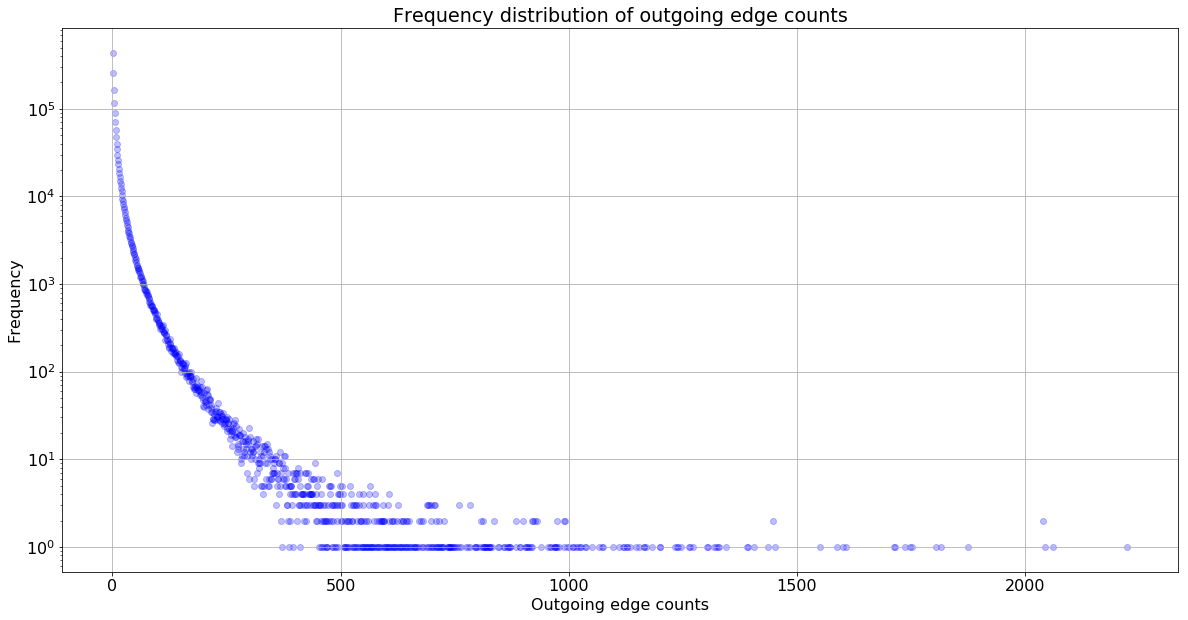

In [124]:
my_alpha = 0.25
plt.scatter(start_nodes_edge_counts_freq.index.values, start_nodes_edge_counts_freq.values, \
            c="b", alpha=my_alpha)
#plt.xscale("log")
plt.yscale("log")
plt.xlabel('Outgoing edge counts')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of outgoing edge counts");

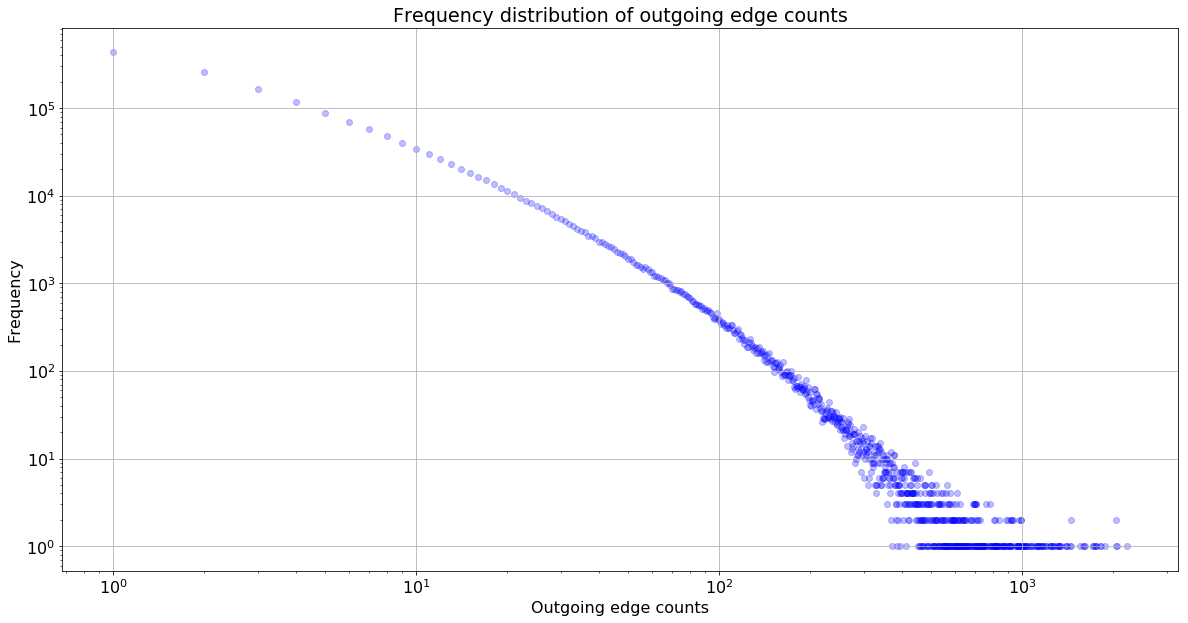

In [125]:
my_alpha = 0.25
plt.scatter(start_nodes_edge_counts_freq.index.values, start_nodes_edge_counts_freq.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Outgoing edge counts')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of outgoing edge counts");

#### Top authorities

In [126]:
edges_count = link_edges.groupby("curr").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = link_edges.groupby("curr").n.sum()
traffic_volume.rename("traffic_volume", inplace=True)

end_nodes = pd.concat([edges_count, traffic_volume], axis=1)
end_nodes["edges_count_pct"] = end_nodes["edges_count"] / end_nodes["edges_count"].sum()
end_nodes["traffic_volume_pct"] = end_nodes["traffic_volume"] / end_nodes["traffic_volume"].sum()

In [127]:
end_nodes.sort_values("traffic_volume", ascending=False, inplace=True)

In [129]:
end_nodes.describe()

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
count,2598302.0000,2598302.0000,2598302.0000,2598302.0000
mean,6.8705,661.3547,0.0000,0.0000
std,20.7608,4031.2270,0.0000,0.0000
min,1.0000,10.0000,0.0000,0.0000
25%,1.0000,26.0000,0.0000,0.0000
50%,2.0000,79.0000,0.0000,0.0000
75%,6.0000,302.0000,0.0000,0.0000
max,6368.0000,1217004.0000,0.0004,0.0007


In [128]:
end_nodes.head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
curr,,,,
Lisa_Bonet,53,1217004,0.0000,0.0007
George_H._W._Bush,956,1108189,0.0001,0.0006
George_W._Bush,1002,907853,0.0001,0.0005
Nick_Jonas,152,776311,0.0000,0.0005
Bird_Box_(film),42,682992,0.0000,0.0004
Jason_Momoa,91,639353,0.0000,0.0004
Dorothy_Bush_Koch,34,605207,0.0000,0.0004
Avengers:_Endgame,230,603912,0.0000,0.0004
Zoë_Kravitz,90,598633,0.0000,0.0003


In [138]:
end_nodes.tail(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
curr,,,,
Leven_Powell,1,10,0.0000,0.0000
Levent_(Istanbul_Metro),1,10,0.0000,0.0000
Levent_Üzümcü,1,10,0.0000,0.0000
Leverage_Factory,1,10,0.0000,0.0000
Leverhulme_Medal_(Royal_Society),1,10,0.0000,0.0000
Leverhulme_Park,1,10,0.0000,0.0000
Leverkusener_Jazztage,1,10,0.0000,0.0000
Levett_Hanson,1,10,0.0000,0.0000
"Levi,_Ray_&_Shoup",1,10,0.0000,0.0000


In [130]:
end_nodes_traffic_freq = end_nodes.traffic_volume.value_counts()

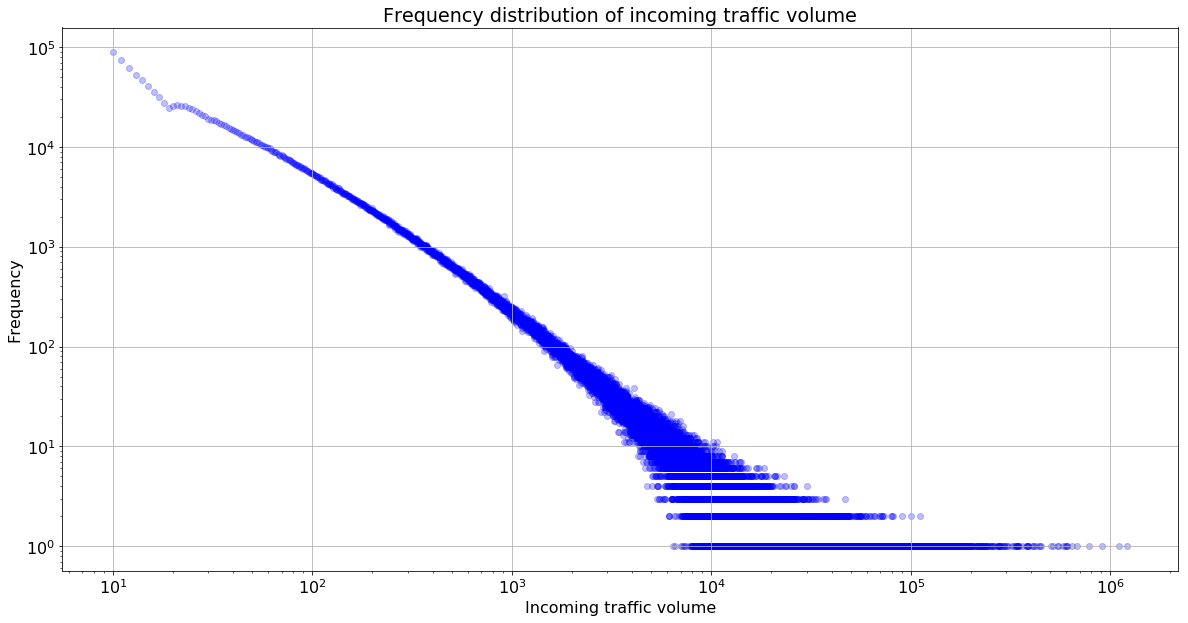

In [131]:
my_alpha = 0.25
plt.scatter(end_nodes_traffic_freq.index.values, end_nodes_traffic_freq.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Incoming traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of incoming traffic volume");

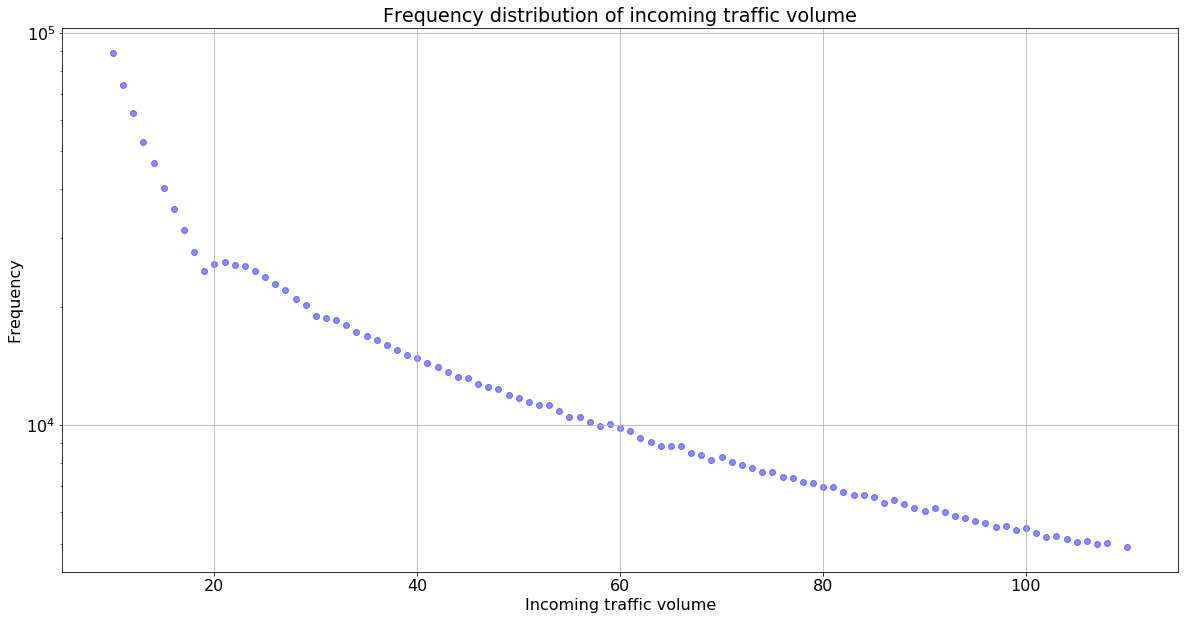

In [132]:
my_alpha = 0.45
plt.scatter(end_nodes_traffic_freq[:100].index.values, end_nodes_traffic_freq[:100].values, \
            c="b", alpha=my_alpha)
#plt.xscale("log")
plt.yscale("log")
plt.xlabel('Incoming traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of incoming traffic volume");

In [133]:
end_nodes_traffic_freq.sort_index().head(30)

10    89052
11    73958
12    62474
13    52838
14    46624
15    40388
16    35574
17    31404
18    27751
19    24816
20    25743
21    26048
22    25689
23    25512
24    24748
25    23875
26    22986
27    22114
28    20960
29    20282
30    19022
31    18773
32    18516
33    18061
34    17314
35    16856
36    16513
37    16064
38    15543
39    15095
Name: traffic_volume, dtype: int64

In [135]:
end_nodes_edge_counts_freq = end_nodes.edges_count.value_counts()

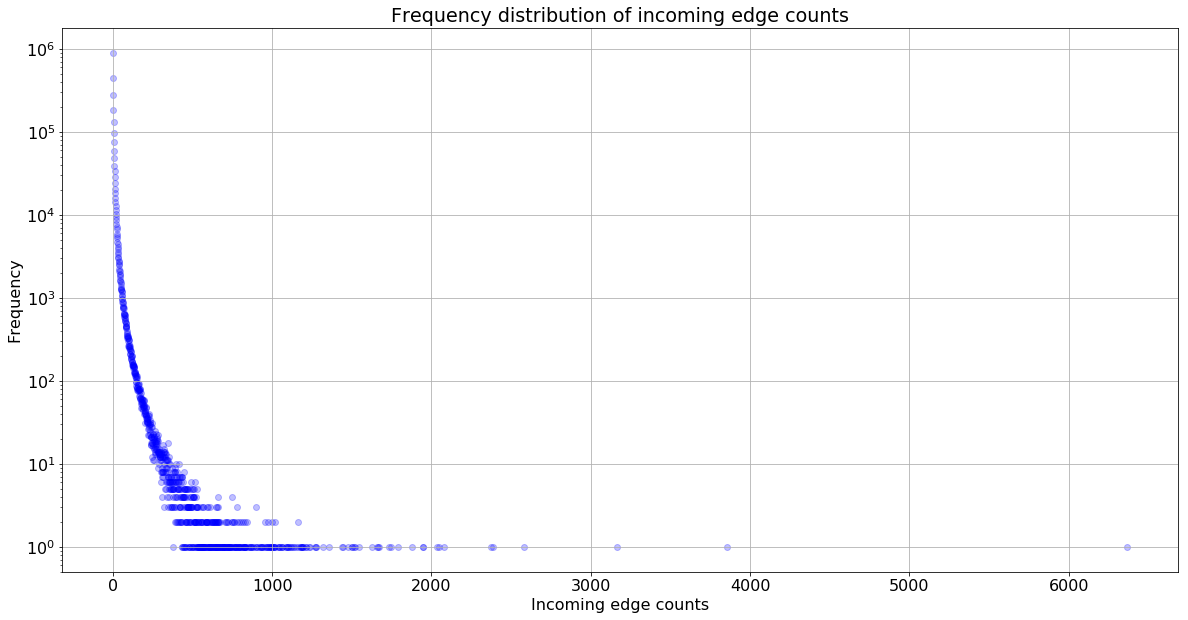

In [136]:
my_alpha = 0.25
plt.scatter(end_nodes_edge_counts_freq.index.values, end_nodes_edge_counts_freq.values, \
            c="b", alpha=my_alpha)
#plt.xscale("log")
plt.yscale("log")
plt.xlabel('Incoming edge counts')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of incoming edge counts");

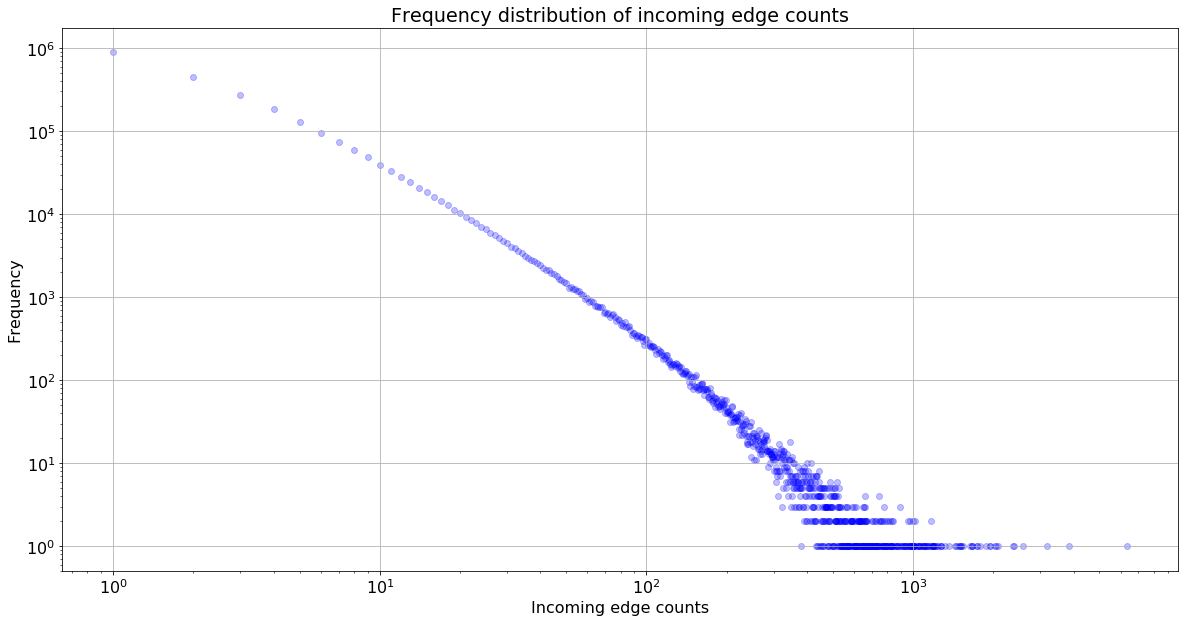

In [137]:
my_alpha = 0.25
plt.scatter(end_nodes_edge_counts_freq.index.values, end_nodes_edge_counts_freq.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Incoming edge counts')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of incoming edge counts");

### Internal search from Wikipedia pages
'Other' reference type

In [19]:
other_edges.describe(include='all')

,prev,curr,type,n
count,1005180,1005180,1005180,1005180.00
unique,302292,414847,1,nan
top,Main_Page,Hyphen-minus,other,nan
freq,257794,127458,1005180,nan
mean,NaN,NaN,NaN,59.71
std,NaN,NaN,NaN,3080.46
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,12.00
50%,NaN,NaN,NaN,18.00
75%,NaN,NaN,NaN,35.00


In [88]:
other_edges.head(20)

,prev,curr,type,n
727986,Main_Page,Hyphen-minus,other,2838090
1395264,Main_Page,Lists_of_deaths_by_year,other,1065668
21252593,Main_Page,George_H._W._Bush,other,220667
15997541,Main_Page,Yellow_vests_movement,other,178234
21175288,Main_Page,Balangiga_bells,other,171702
6426095,Main_Page,Pineapple,other,170129
23370493,Main_Page,2018_Sunda_Strait_tsunami,other,100842
28097656,Main_Page,2018_Strasbourg_attack,other,98728
5564468,Main_Page,Voyager_2,other,83172
12932182,Main_Page,OSIRIS-REx,other,78426


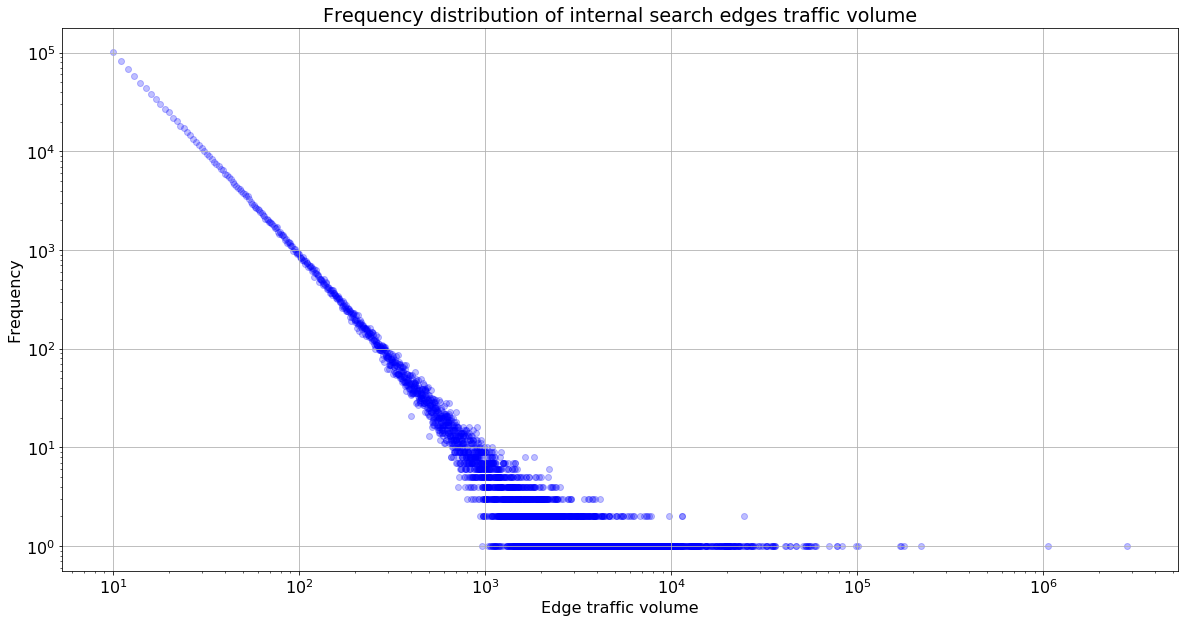

In [89]:
my_alpha = 0.25
plt.scatter(other_edges_traffic_frequencies.index.values, other_edges_traffic_frequencies.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of internal search edges traffic volume");

#### Top hubs

In [155]:
edges_count = other_edges.groupby("prev").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = other_edges.groupby("prev").n.sum()
traffic_volume.rename("traffic_volume", inplace=True)

start_nodes = pd.concat([edges_count, traffic_volume], axis=1)
start_nodes["edges_count_pct"] = start_nodes["edges_count"] / start_nodes["edges_count"].sum()
start_nodes["traffic_volume_pct"] = start_nodes["traffic_volume"] / start_nodes["traffic_volume"].sum()

In [156]:
start_nodes.sort_values("traffic_volume", ascending=False, inplace=True)

In [157]:
start_nodes.describe()

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
count,302292.0000,302292.0000,302292.0000,302292.0000
mean,3.3252,198.5578,0.0000,0.0000
std,468.9605,59069.7268,0.0005,0.0010
min,1.0000,10.0000,0.0000,0.0000
25%,1.0000,14.0000,0.0000,0.0000
50%,1.0000,27.0000,0.0000,0.0000
75%,3.0000,66.0000,0.0000,0.0000
max,257794.0000,32475706.0000,0.2565,0.5411


In [158]:
start_nodes.head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
prev,,,,
Main_Page,257794,32475706,0.2565,0.5411
Wiki,3778,138360,0.0038,0.0023
Welcome_to_Marwen,109,72643,0.0001,0.0012
George_H._W._Bush,377,70544,0.0004,0.0012
Ralph_Breaks_the_Internet,212,67236,0.0002,0.0011
Wikipedia,1998,59717,0.0020,0.0010
Jason_Momoa,183,50044,0.0002,0.0008
Aquaman_(film),588,46824,0.0006,0.0008
2.0_(film),255,46226,0.0003,0.0008


In [161]:
start_nodes_traffic_freq = start_nodes.traffic_volume.value_counts()

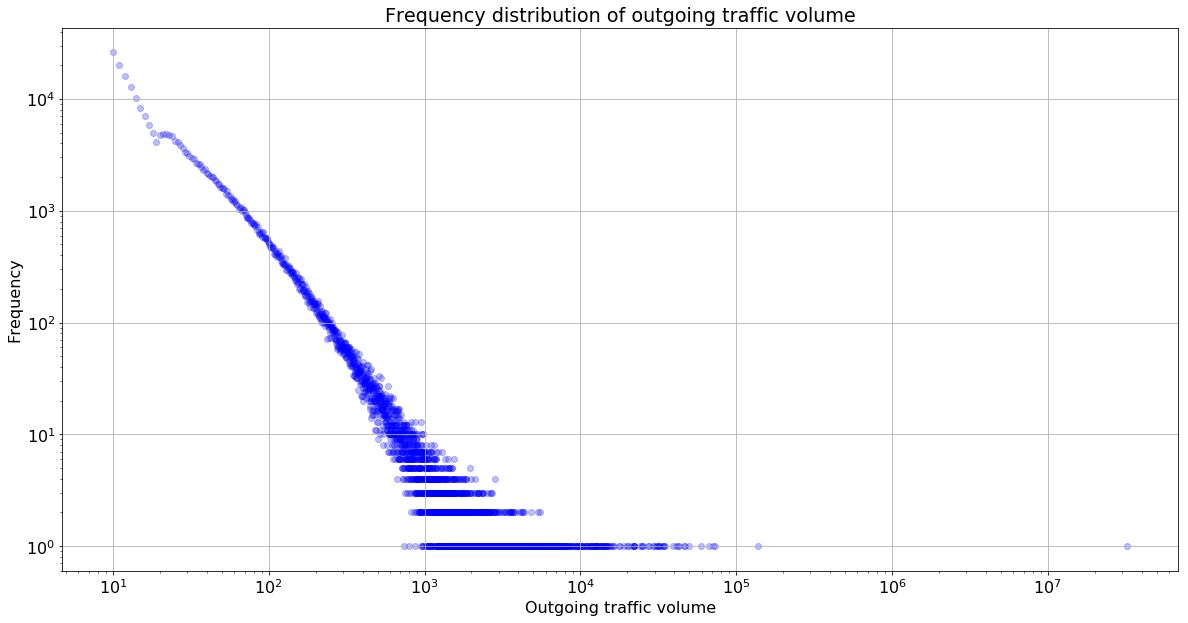

In [162]:
my_alpha = 0.25
plt.scatter(start_nodes_traffic_freq.index.values, start_nodes_traffic_freq.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Outgoing traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of outgoing traffic volume");

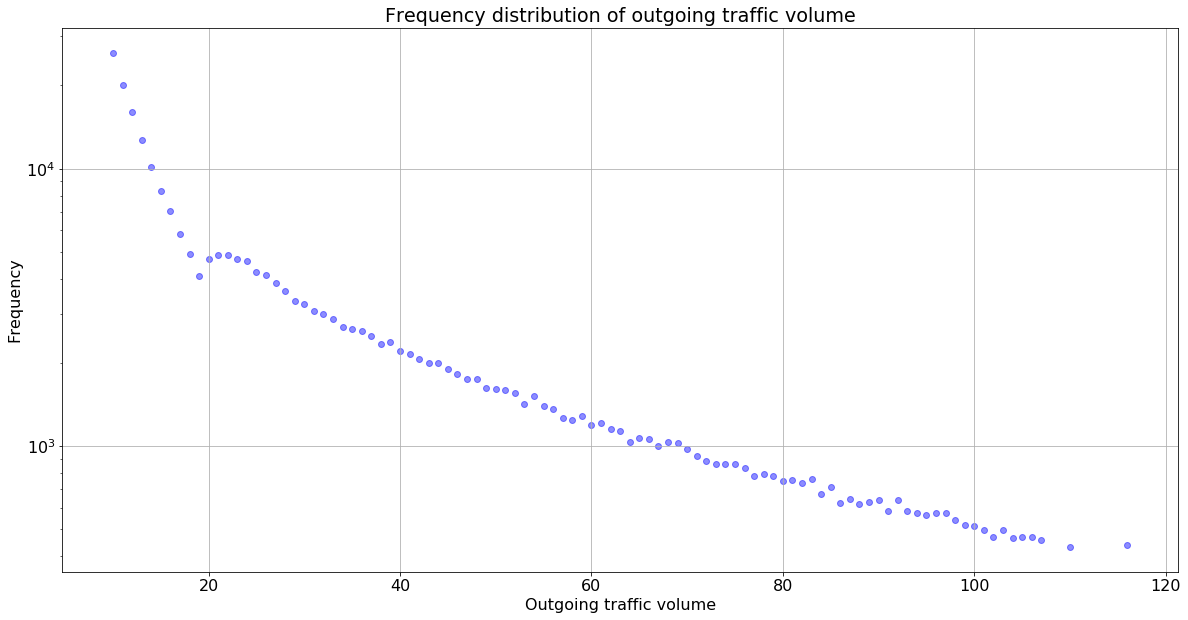

In [165]:
my_alpha = 0.45
plt.scatter(start_nodes_traffic_freq[:100].index.values, start_nodes_traffic_freq[:100].values, \
            c="b", alpha=my_alpha)
#plt.xscale("log")
plt.yscale("log")
plt.xlabel('Outgoing traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of outgoing traffic volume");

In [166]:
start_nodes_traffic_freq.sort_index().head(30)

10    26164
11    20095
12    15955
13    12713
14    10129
15     8315
16     7022
17     5802
18     4926
19     4114
20     4717
21     4876
22     4888
23     4738
24     4662
25     4228
26     4123
27     3885
28     3621
29     3326
30     3251
31     3079
32     2991
33     2873
34     2697
35     2638
36     2603
37     2485
38     2328
39     2373
Name: traffic_volume, dtype: int64

In [167]:
start_nodes.sort_values("edges_count", ascending=False).head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
prev,,,,
Main_Page,257794,32475706,0.2565,0.5411
Wiki,3778,138360,0.0038,0.0023
Wikipedia,1998,59717,0.0020,0.0010
Aquaman_(film),588,46824,0.0006,0.0008
English_Wikipedia,539,20313,0.0005,0.0003
Bird_Box_(film),413,29267,0.0004,0.0005
Spider-Man:_Into_the_Spider-Verse,407,31021,0.0004,0.0005
2018_in_film,394,13069,0.0004,0.0002
George_H._W._Bush,377,70544,0.0004,0.0012


In [168]:
start_nodes_edge_counts_freq = start_nodes.edges_count.value_counts()

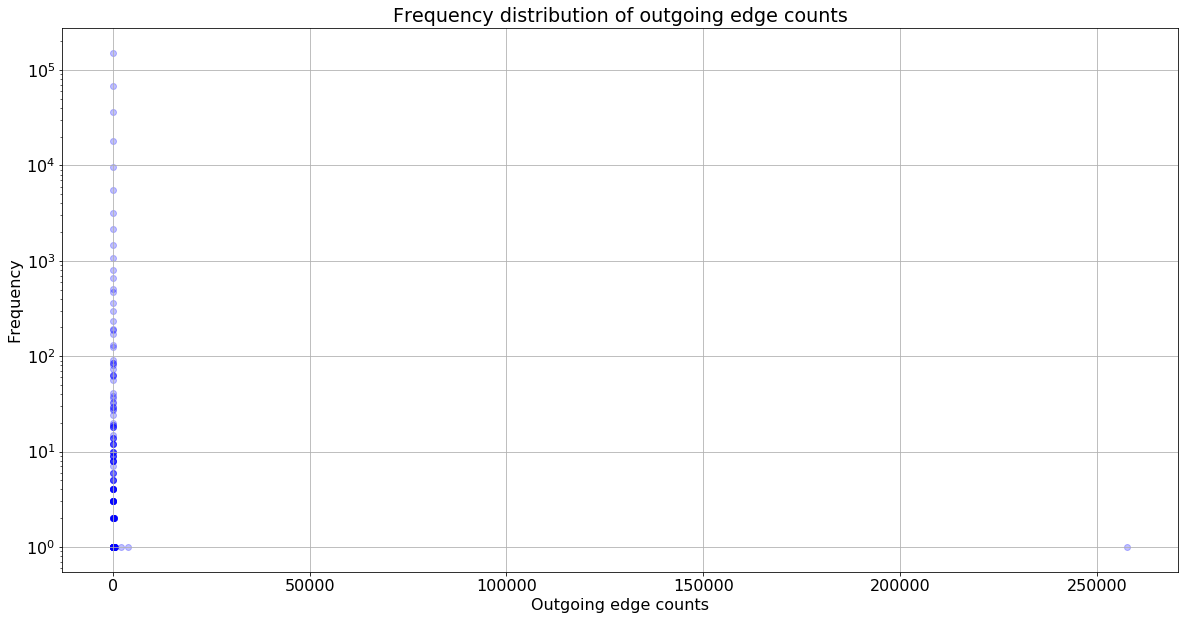

In [172]:
my_alpha = 0.25
plt.scatter(start_nodes_edge_counts_freq.index.values, start_nodes_edge_counts_freq.values, \
            c="b", alpha=my_alpha)
#plt.xscale("log")
plt.yscale("log")
plt.xlabel('Outgoing edge counts')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of outgoing edge counts");

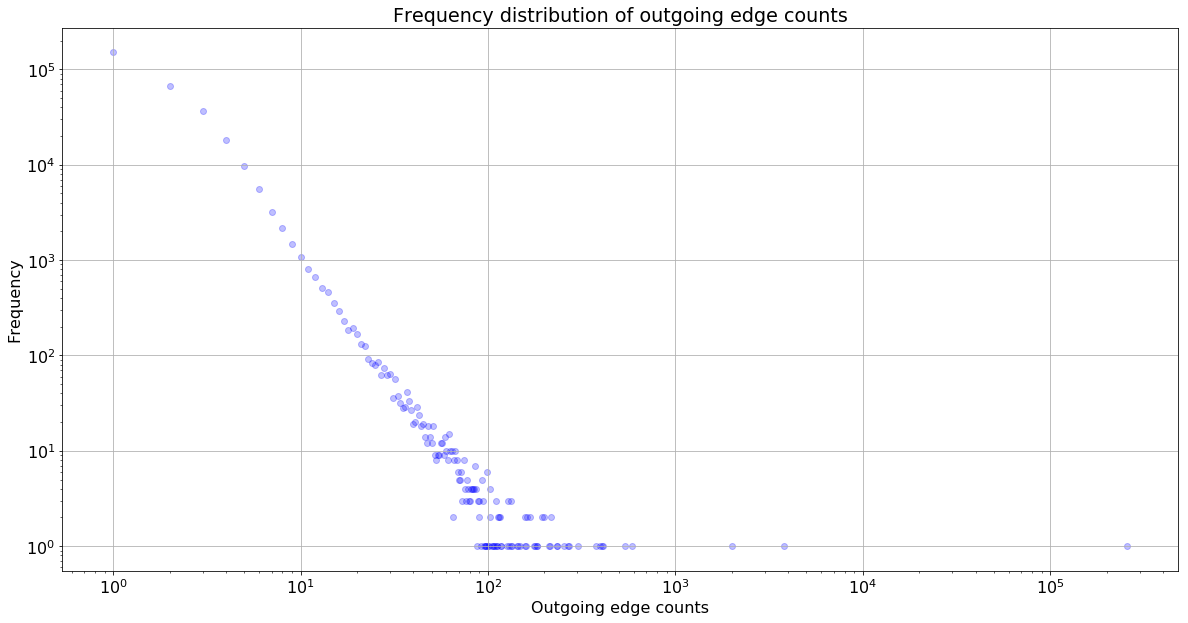

In [171]:
my_alpha = 0.25
plt.scatter(start_nodes_edge_counts_freq.index.values, start_nodes_edge_counts_freq.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Outgoing edge counts')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of outgoing edge counts");

#### Top authorities

In [173]:
edges_count = other_edges.groupby("curr").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = other_edges.groupby("curr").n.sum()
traffic_volume.rename("traffic_volume", inplace=True)

end_nodes = pd.concat([edges_count, traffic_volume], axis=1)
end_nodes["edges_count_pct"] = end_nodes["edges_count"] / end_nodes["edges_count"].sum()
end_nodes["traffic_volume_pct"] = end_nodes["traffic_volume"] / end_nodes["traffic_volume"].sum()

In [174]:
end_nodes.sort_values("traffic_volume", ascending=False, inplace=True)

In [175]:
end_nodes.describe()

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
count,414847.0000,414847.0000,414847.0000,414847.0000
mean,2.4230,144.6857,0.0000,0.0000
std,261.4296,13425.0331,0.0003,0.0002
min,1.0000,10.0000,0.0000,0.0000
25%,1.0000,14.0000,0.0000,0.0000
50%,1.0000,26.0000,0.0000,0.0000
75%,2.0000,64.0000,0.0000,0.0000
max,127458.0000,7557718.0000,0.1268,0.1259


In [176]:
end_nodes.head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
curr,,,,
Hyphen-minus,127458,7557718,0.1268,0.1259
Main_Page,110009,4013760,0.1094,0.0669
Lists_of_deaths_by_year,275,1074677,0.0003,0.0179
George_H._W._Bush,228,226297,0.0002,0.0038
Yellow_vests_movement,25,178842,0.0000,0.0030
Balangiga_bells,2,171835,0.0000,0.0029
Pineapple,27,170638,0.0000,0.0028
2018_Sunda_Strait_tsunami,4,100893,0.0000,0.0017
2018_Strasbourg_attack,6,99298,0.0000,0.0017


In [177]:
end_nodes.tail(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
curr,,,,
Melrose_Place_(season_1),1,10,0.0000,0.0000
Māui_(mythology),1,10,0.0000,0.0000
A_Thousand_Acres,1,10,0.0000,0.0000
Hanjin_Shipping,1,10,0.0000,0.0000
Fauxtography,1,10,0.0000,0.0000
Club_Life:_Volume_Four_New_York_City,1,10,0.0000,0.0000
UFF,1,10,0.0000,0.0000
UFC_on_Fox:_Poirier_vs._Gaethje,1,10,0.0000,0.0000
Joseph_Phan,1,10,0.0000,0.0000


In [178]:
end_nodes_traffic_freq = end_nodes.traffic_volume.value_counts()

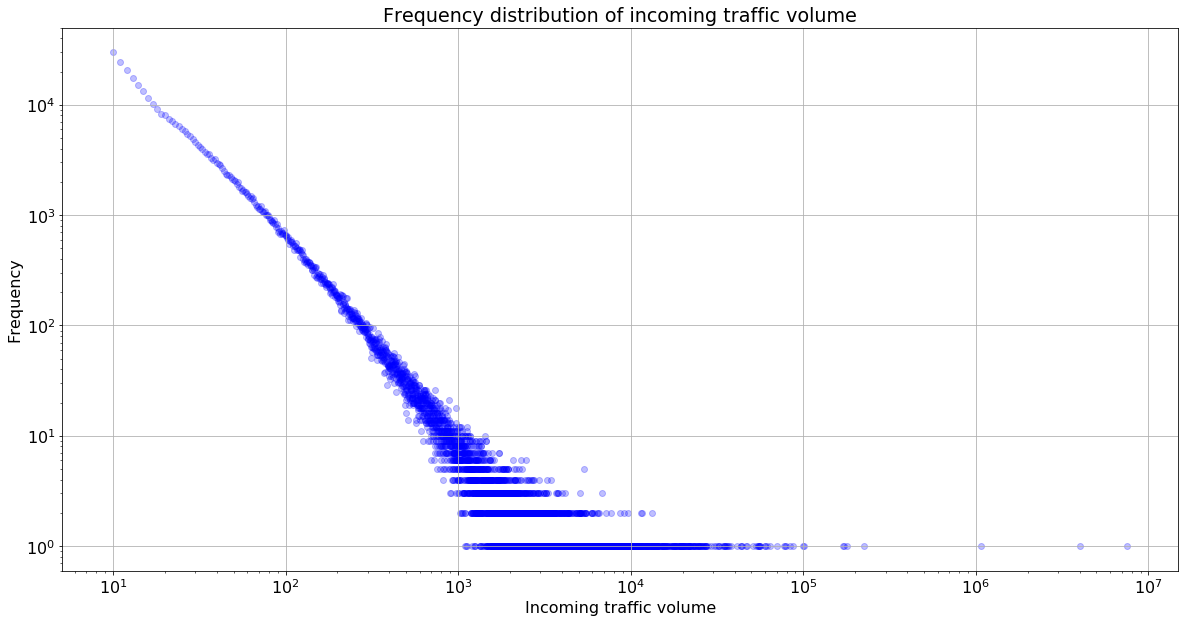

In [179]:
my_alpha = 0.25
plt.scatter(end_nodes_traffic_freq.index.values, end_nodes_traffic_freq.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Incoming traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of incoming traffic volume");

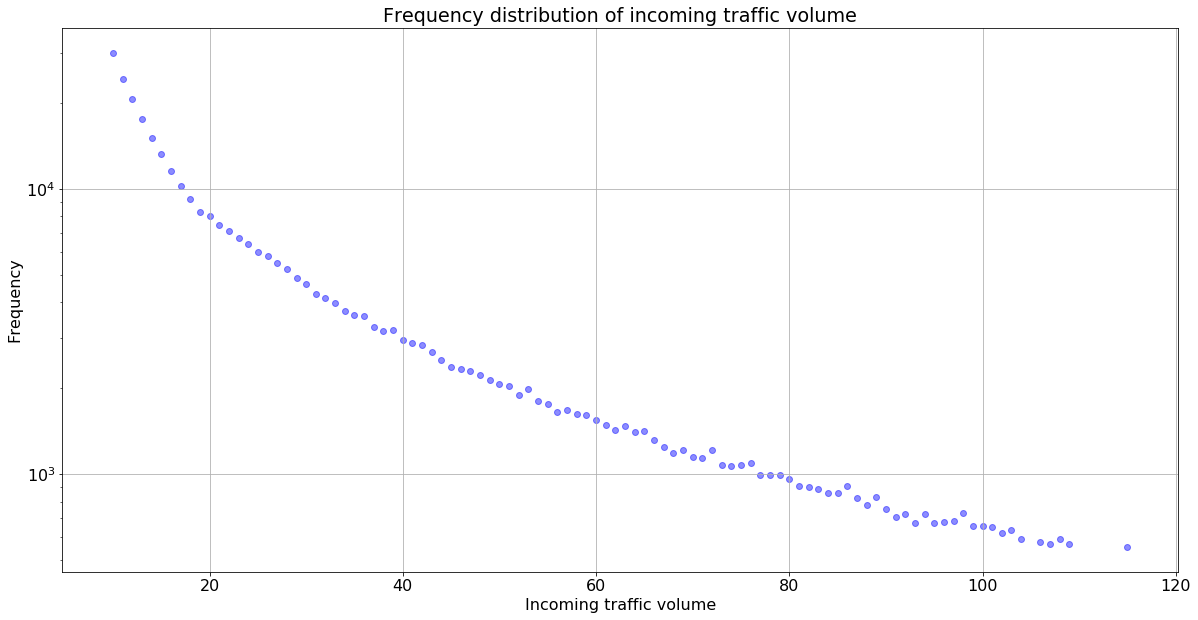

In [180]:
my_alpha = 0.45
plt.scatter(end_nodes_traffic_freq[:100].index.values, end_nodes_traffic_freq[:100].values, \
            c="b", alpha=my_alpha)
#plt.xscale("log")
plt.yscale("log")
plt.xlabel('Incoming traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of incoming traffic volume");

In [181]:
end_nodes_traffic_freq.sort_index().head(30)

10    29958
11    24306
12    20706
13    17637
14    15068
15    13227
16    11528
17    10213
18     9193
19     8265
20     8059
21     7465
22     7130
23     6714
24     6415
25     6010
26     5829
27     5476
28     5255
29     4878
30     4642
31     4297
32     4158
33     3995
34     3718
35     3611
36     3578
37     3272
38     3184
39     3197
Name: traffic_volume, dtype: int64

In [182]:
end_nodes_edge_counts_freq = end_nodes.edges_count.value_counts()

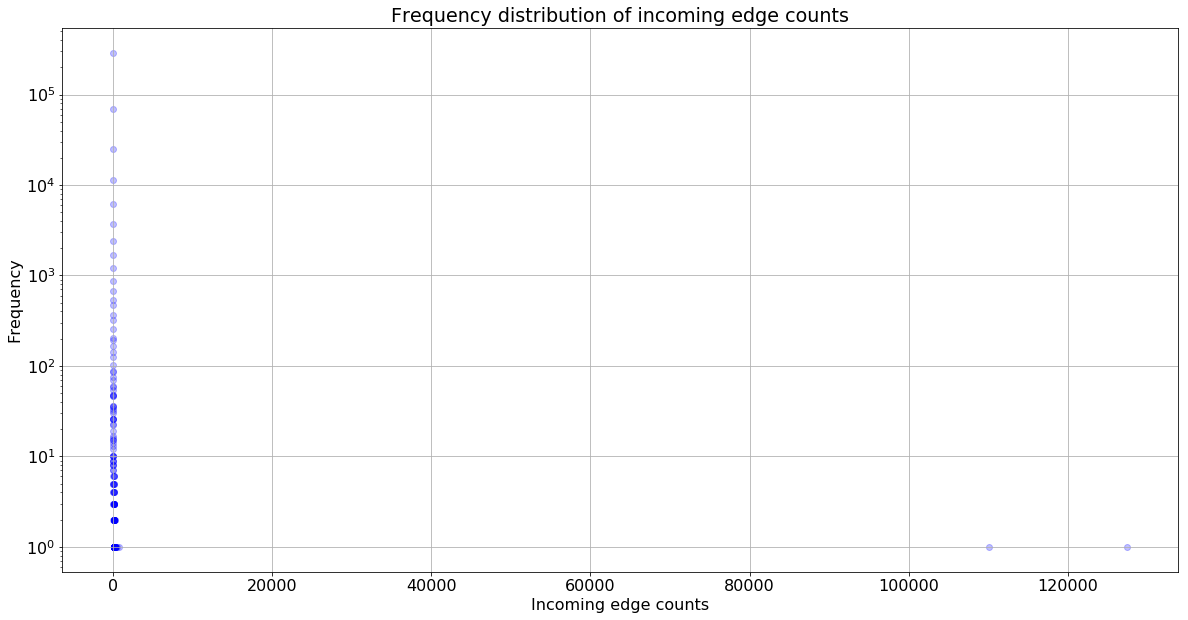

In [183]:
my_alpha = 0.25
plt.scatter(end_nodes_edge_counts_freq.index.values, end_nodes_edge_counts_freq.values, \
            c="b", alpha=my_alpha)
#plt.xscale("log")
plt.yscale("log")
plt.xlabel('Incoming edge counts')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of incoming edge counts");

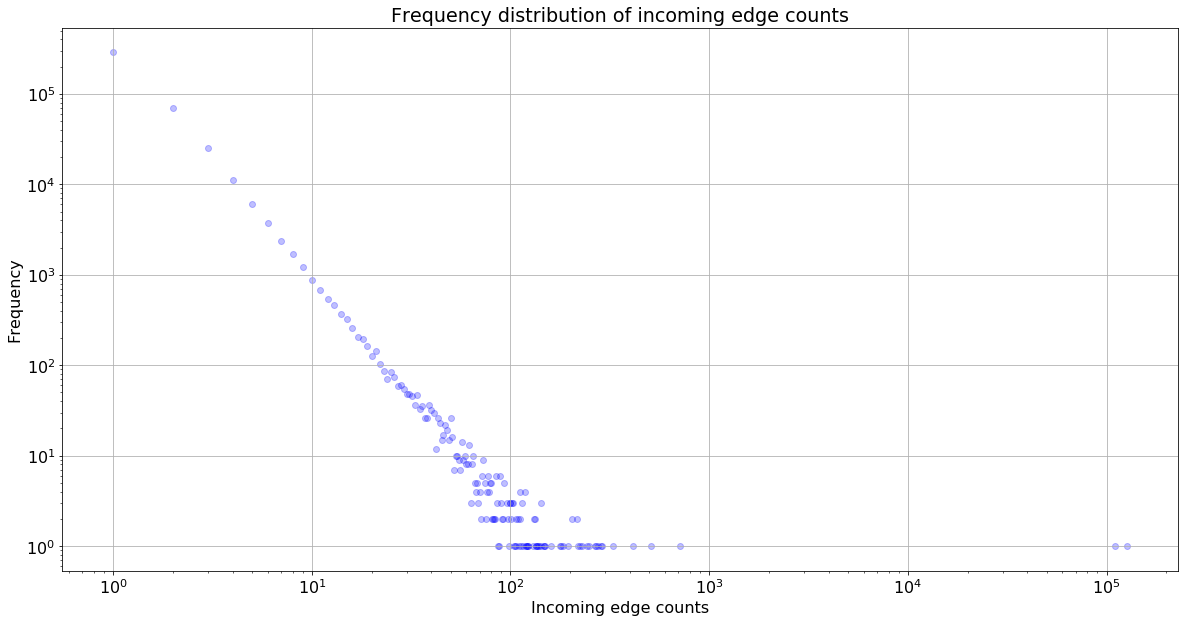

In [184]:
my_alpha = 0.25
plt.scatter(end_nodes_edge_counts_freq.index.values, end_nodes_edge_counts_freq.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Incoming edge counts')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of incoming edge counts");